In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
 
df=pd.read_csv("AirPassengers.csv")
 
#We need to set the Month column as index and convert it into datetimedata.set_index("Month", inplace = True) 

df.set_index("Month",inplace=True)
df.index=pd.to_datetime(df.index)
df



,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


<AxesSubplot:xlabel='Month'>

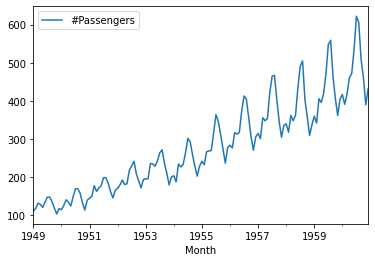

In [2]:
df.plot()


Grafikten görüldüğü üzere, zaman içinde bir trend var ve bu da verilerin durağan olmadığını gösteriyor. Ancak emin olmak için bir Augmented Dickey-Fuller testi kullanacağız.

In [3]:
from statsmodels.tsa.stattools import adfuller


result=adfuller(df['#Passengers'])


dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))
{'adf': 0.8153688792060468,
 'pvalue': 0.991880243437641,
 'usedlag': 13,
 'nobs': 130,
 'criticalvalues': {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 'icbest': 996.692930839019}

{'adf': 0.8153688792060468,
 'pvalue': 0.991880243437641,
 'usedlag': 13,
 'nobs': 130,
 'criticalvalues': {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 'icbest': 996.692930839019}

In [4]:
df['1difference']=df['#Passengers']-df['#Passengers'].shift(1)

<AxesSubplot:xlabel='Month'>

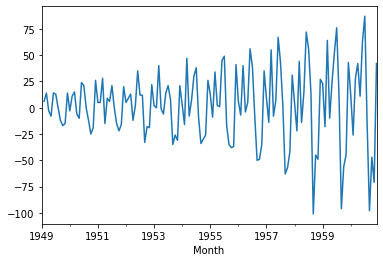

In [5]:
df['1difference'].plot()


In [6]:
#note we are dropping na values because the first value of the first difference is NA
result=adfuller(df['1difference'].dropna())
result

(-2.8292668241700034,
 0.054213290283824954,
 12,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 988.5069317854084)

p-değeri>0.05 olduğu için serinin durağan olmadığını ve ikinci farkı alarak tekrar fark almamız gerektiğini gösterir. İkinci fark birinci fark olarak hesaplanabilir ancak bu sefer gözlemleri kullanmak yerine birinci farkı kullanacağız.

<AxesSubplot:xlabel='Month'>

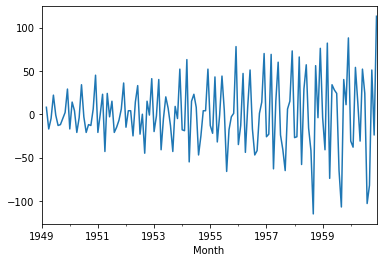

In [7]:
df['2difference']=df['1difference']-df['1difference'].shift(1)
df['2difference'].plot()

In [8]:
result=adfuller(df['2difference'].dropna())
result

(-16.384231542468488,
 2.7328918500143186e-29,
 11,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 988.6020417275604)

p değeri<0,05. Bu, ikinci farkın durağan olduğu ve d değeri için iyi bir tahminin 2 olduğu anlamına gelir.

Verilerimiz mevsimseldir, dolayısıyla d değeriyle aynı olan ancak Mevsimsel Fark için D değerini de tahmin etmemiz gerekir. Mevsimsel fark, verileri sezon başına satır sayısına göre kaydırarak (örneğimizde yılda 12 ay) ve bunları önceki sezondan çıkararak hesaplanabilir. 

mevsimsel fark(T) = gözlem(T) — gözlem(T-12)

mevsimsel ilk fark(T) = mevsimsel fark(T) — mevsimsel fark(T-1)

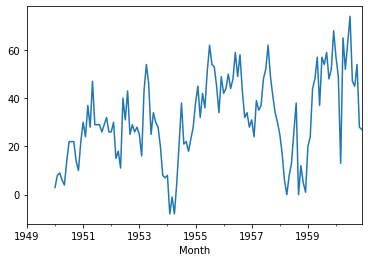

In [9]:
df['Seasonal_Difference']=df['#Passengers']-df['#Passengers'].shift(12)


ax=df['Seasonal_Difference'].plot()

In [10]:
result=adfuller((df['Seasonal_Difference']).dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -3.3830207264924805,
 'pvalue': 0.011551493085514982,
 'usedlag': 1,
 'nobs': 130,
 'criticalvalues': {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 'icbest': 919.527129208137}

p değeri 0,05'ten küçüktür, bu nedenle durağandır ve fark almamız gerekmez. Bu, D değeri için 0 kullanılmasını önerir.

# (ACF ve PACF)( (p,q ve P, Q parametreleri)
ARIMA modelinden önceki son adım, p,q, P ve Q parametrelerini tahmin etmemize yardımcı olacak Otokorelasyon ve Kısmi Otokorelasyon Grafiklerini oluşturmaktır.
Otokorelasyon ve Kısmi Otokorelasyon Grafiklerine bakarak parametreleri tahmin etmemize yardımcı olmak için kullandığımız ARIMA ve Mevsimsel ARIMA modelleri için çok faydalı bazı kurallar vardır. Zaman serilerimizin ikinci farkı ve mevsimsel farkı için grafikleri oluşturacağız çünkü bunlar ARIMA'da kullandığımız durağan seriler (d=2, D=0).
İlk olarak, ikinci fark için ACF ve PACF'yi çizelim.

C:\Users\Burak\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


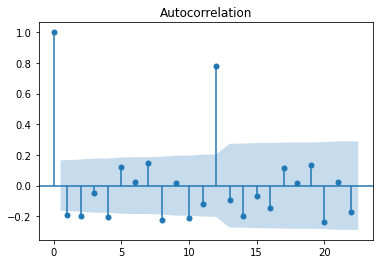

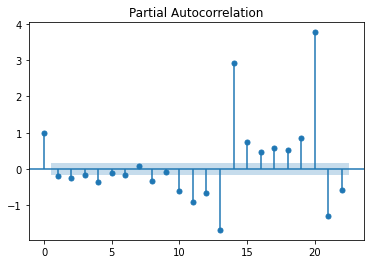

In [11]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig1=plot_acf(df['2difference'].dropna())

fig2=plot_pacf(df['2difference'].dropna())

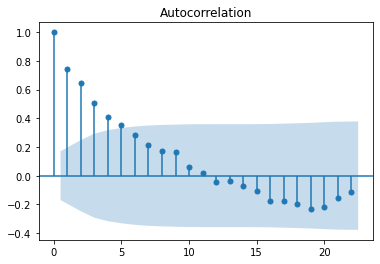

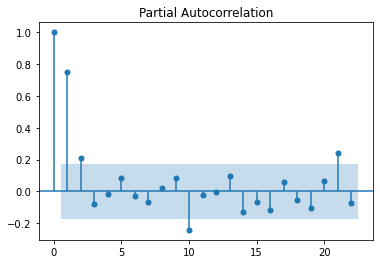

In [12]:
fig1=plot_acf(df['Seasonal_Difference'].dropna())
fig2=plot_pacf(df['Seasonal_Difference'].dropna())

# The ARIMA Model

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(df['#Passengers'],order=(1,2,1),seasonal_order=(1, 0, 0, 12))
result=model.fit()



C:\Users\Burak\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Burak\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Modelin ne kadar iyi oturduğuna dair bir fikir sahibi olmak için modelin residual değerleri grafik üzerine çizdirilir.. Temel olarak residual değerleri, orijinal değerler ile modelden tahmin edilen değerler arasındaki farktır.

<AxesSubplot:ylabel='Density'>

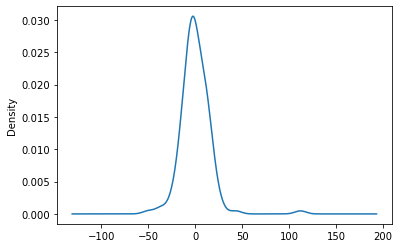

In [14]:
result.resid.plot(kind='kde')

In [15]:
df.index[-1]

Timestamp('1960-12-01 00:00:00')

# Tahmin oluşturma

Gelecekteki değerleri tahmin edebilebilmesi için verileri eklemek için bazı gelecek tarihler oluşturulur.

In [16]:
from pandas.tseries.offsets import DateOffset


new_dates=[df.index[-1]+DateOffset(months=x) for x in range(1,500)]
df_pred=pd.DataFrame(index=new_dates,columns =df.columns)
df_pred

,#Passengers,1difference,2difference,Seasonal_Difference
1961-01-01,NaN,NaN,NaN,NaN
1961-02-01,NaN,NaN,NaN,NaN
1961-03-01,NaN,NaN,NaN,NaN
1961-04-01,NaN,NaN,NaN,NaN
1961-05-01,NaN,NaN,NaN,NaN
...,...,...,...,...
2002-03-01,NaN,NaN,NaN,NaN
2002-04-01,NaN,NaN,NaN,NaN
2002-05-01,NaN,NaN,NaN,NaN
2002-06-01,NaN,NaN,NaN,NaN


ARIMA modeli, tarih aralığını değil, numaralandırılmış dizinin başlangıcını ve sonunu argüman olarak almayı öngörür.
Gelecek tarihleri indeksleyen boş bir veri çerçevesi oluşturulur ve bunlar orjinal veriler ile birleştirilir. 

<AxesSubplot:>

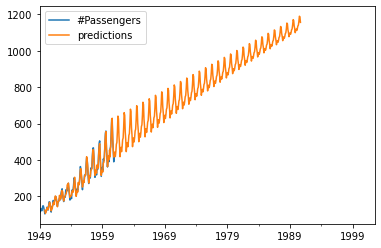

In [21]:
df2=pd.concat([df,df_pred])
df2['predictions']=result.predict(start=10,end=500)
df2[['#Passengers','predictions']].plot()


Genel olarak:
    
    ARIMA modelini çalıştırmak için kullandığımız işlem hattı şudur:
Mevsimlik mi yoksa Mevsimlik mi olduğunu anlamak için zaman serilerinize bakın.


d ve D değerleri için bir tahmin elde etmek üzere durağanlığa ulaşmak için gerekirse zaman serilerine ve mevsimsel farka fark uygulayın.



p, P ve q, Q değerlerini tahmin etmenize yardımcı olması için Otokorelasyon ve Kısmi Otokorelasyon grafiklerini çizin.


ARIMA'nın genel kurallarına göre parametreleri değiştirerek gerekirse modele ince ayar yapın